In [1]:
import numpy as np
import pandas as pd
import pypsa
import highspy 

%matplotlib inline

In [2]:
DATA_FILE = 'pypsa-eu-uk-2030.xlsx'

In [3]:
load = pd.read_excel(DATA_FILE, sheet_name='load', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
load_hydrogen = pd.read_excel(DATA_FILE, sheet_name='load_hydrogen', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
pv = pd.read_excel(DATA_FILE, sheet_name='pv', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
wind = pd.read_excel(DATA_FILE, sheet_name='wind', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
wind_offshore = pd.read_excel(DATA_FILE, sheet_name='wind_offshore', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
ror = pd.read_excel(DATA_FILE, sheet_name='ror', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
inflow = pd.read_excel(DATA_FILE, sheet_name='inflow', parse_dates=['t'], index_col='t',usecols='A:AK').dropna(axis=1, how='all').dropna()
chp = pd.read_excel(DATA_FILE, sheet_name='chp', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()
chp_bio = pd.read_excel(DATA_FILE, sheet_name='chp_bio', parse_dates=['t'], index_col='t').dropna(axis=1, how='all').dropna()

buses = pd.read_excel(DATA_FILE, sheet_name='buses', index_col=0, usecols='A:G')
cbf_buses = pd.read_excel(DATA_FILE, sheet_name='cbf_buses', index_col=0, usecols='A:F')
buses_hydrogen = pd.read_excel(DATA_FILE, sheet_name='buses_hydrogen', index_col=0, usecols='A:G')
lines = pd.read_excel(DATA_FILE, sheet_name='lines', index_col='name').dropna(axis=1, how='all').dropna()
links = pd.read_excel(DATA_FILE, sheet_name='links', index_col=0, usecols='A:G').dropna(axis=1, how='all').dropna()
links_electrolysis = pd.read_excel(DATA_FILE, sheet_name='links_electrolysis', index_col=0, usecols='A:I').dropna(axis=1, how='all').dropna()
gen_pv = pd.read_excel(DATA_FILE, sheet_name='gen_pv', index_col=0, usecols='A:E')
gen_wind = pd.read_excel(DATA_FILE, sheet_name='gen_wind', index_col=0, usecols='A:E')
gen_wind_offshore = pd.read_excel(DATA_FILE, sheet_name='gen_wind_offshore', index_col=0, usecols='A:E')
gen_gas = pd.read_excel(DATA_FILE, sheet_name='gen_gas', index_col=0, usecols='A:J')
gen_oil = pd.read_excel(DATA_FILE, sheet_name='gen_oil', index_col=0, usecols='A:J')
gen_coal = pd.read_excel(DATA_FILE, sheet_name='gen_coal', index_col=0,usecols='A:J')
gen_nuclear = pd.read_excel(DATA_FILE, sheet_name='gen_nuclear', index_col=0, usecols='A:I')
gen_biomass = pd.read_excel(DATA_FILE, sheet_name='gen_biomass', index_col=0, usecols='A:G')
gen_biogas = pd.read_excel(DATA_FILE, sheet_name='gen_biogas', index_col=0, usecols='A:G')
gen_ror = pd.read_excel(DATA_FILE, sheet_name='gen_ror', index_col=0, usecols='A:E')
gen_reservoir = pd.read_excel(DATA_FILE, sheet_name='gen_reservoir', index_col=0, usecols='A:E')
gen_other_res = pd.read_excel(DATA_FILE, sheet_name='gen_other_res', index_col=0, usecols='A:F')
gen_dsr = pd.read_excel(DATA_FILE, sheet_name='gen_dsr', index_col=0, usecols='A:F')
gen_gas_chp = pd.read_excel(DATA_FILE, sheet_name='gen_gas_chp', index_col=0, usecols='A:J')
gen_coal_chp = pd.read_excel(DATA_FILE, sheet_name='gen_coal_chp', index_col=0, usecols='A:J')
gen_oil_chp = pd.read_excel(DATA_FILE, sheet_name='gen_oil_chp', index_col=0, usecols='A:G')
gen_res_chp = pd.read_excel(DATA_FILE, sheet_name='gen_res_chp', index_col=0, usecols='A:G')
gen_bio_chp = pd.read_excel(DATA_FILE, sheet_name='gen_bio_chp', index_col=0, usecols='A:G')
gen_cbf = pd.read_excel(DATA_FILE, sheet_name='gen_cbf', index_col=0, usecols='A:E')
st_hps = pd.read_excel(DATA_FILE, sheet_name='st_hps', index_col=0, usecols='A:I')
st_battery = pd.read_excel(DATA_FILE, sheet_name='st_battery', index_col=0, usecols='A:I')
st_hydrogen = pd.read_excel(DATA_FILE, sheet_name='st_hydrogen', index_col=0, usecols='A:D')
st_other = pd.read_excel(DATA_FILE, sheet_name='st_other', index_col=0, usecols='A:I')

C:\Users\Pawel\AppData\Local\Temp\ipykernel_5744\3741320993.py:13: FutureWarning:

Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.



In [4]:
gas_chp_timeseries=pd.DataFrame(chp,columns=gen_gas_chp.index)
coal_chp_timeseries=pd.DataFrame(chp,columns=gen_coal_chp.index)
oil_chp_timeseries=pd.DataFrame(chp,columns=gen_oil_chp.index)
res_chp_timeseries=pd.DataFrame(chp,columns=gen_res_chp.index)

for col in gas_chp_timeseries.columns:
    gas_chp_timeseries[col].values[:] = chp['chp']

for col in coal_chp_timeseries.columns:
    coal_chp_timeseries[col].values[:] = chp['chp']

for col in oil_chp_timeseries.columns:
    oil_chp_timeseries[col].values[:] = chp['chp']

for col in res_chp_timeseries.columns:
    res_chp_timeseries[col].values[:] = chp['chp']
  

In [60]:
load_hydrogen = load_hydrogen*3

In [61]:
network = pypsa.Network()
network.set_snapshots(load.index)

network.import_components_from_dataframe(buses, 'Bus')
network.import_components_from_dataframe(cbf_buses, 'Bus')
network.import_components_from_dataframe(buses_hydrogen, 'Bus')

network.import_components_from_dataframe(lines, 'Line')
network.lines['s_nom_extendable'] = True  

network.madd("Link", links.index,
             bus0=links['bus0'].tolist(), bus1= links['bus1'].tolist(),
             p_nom=links['p_nom'].tolist())

network.madd("Generator", gen_cbf.index, suffix='_CBF', carrier='CBF',
             bus=gen_cbf.index.tolist(), p_nom=gen_cbf['p_nom'].to_list(), p_nom_extendable=False, 
             marginal_cost=gen_cbf['marginal_cost'].to_list())

dict_carriers = {
    'Lignite': 0.334, 'Hard coal': 0.354, 'Gas': 0.187, 'Gas CCS': 0, 'Oil': 0.334, 'Hydrogen': 0, 'Biomass': 0.403, 'Biogas': 0.178, 'BECCS': 0,
    'Geothermal': 0.026, 'Wind': 0, 'Wind offshore': 0, 'PV': 0, 'HPS': 0, 'Hydro': 0, 'Other RES': 0, 'CBF': 0, 'VOLL': 0, 'Battery': 0, 'Other storage' : 0, 'Nuclear': 0, 'Electrolysis':0, 'Hydrogen storage':0, 'Hydrogen for power':0
}

for carrier in dict_carriers:
    network.add("Carrier", name=carrier, co2_emissions=dict_carriers[carrier])

network.madd("Load", load.columns, bus=load.columns, p_set=load)
network.madd("Load", load_hydrogen.columns, bus=load_hydrogen.columns, p_set=load_hydrogen, carrier='Hydrogen')

Index(['EN_NorthEast_H2', 'EN_NorthWest_H2', 'EN_Yorkshire_H2',
       'EN_EastMidlands_H2', 'EN_WestMidlands_H2', 'EN_East_H2',
       'EN_London_H2', 'EN_SouthEast_H2', 'EN_SouthWest_H2', 'EN_Wales_H2',
       'Scotland_H2', 'NorthernIreland_H2', 'Austria_H2', 'Belgium_H2',
       'Bulgaria_H2', 'Croatia_H2', 'Czechia_H2', 'Denmark_H2', 'Estonia_H2',
       'Finland_H2', 'France_H2', 'Germany_H2', 'Greece_H2', 'Hungary_H2',
       'Ireland_H2', 'Italy_H2', 'Latvia_H2', 'Lithuania_H2', 'Netherlands_H2',
       'Poland_H2', 'Portugal_H2', 'Romania_H2', 'Slovakia_H2', 'Slovenia_H2',
       'Spain_H2', 'Sweden_H2'],
      dtype='object')

In [9]:
network.madd('Generator', 
      gen_pv['bus'],
      suffix='_PV',
      bus=gen_pv['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_pv['p_nom'].to_list(),
      carrier='PV', 
      marginal_cost=gen_pv['marginal_cost'].to_list(), 
      p_max_pu=pv)

network.madd('Generator', 
      gen_wind['bus'],
      suffix='_Wind',
      bus=gen_wind['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_wind['p_nom'].to_list(), 
      carrier='Wind', 
      marginal_cost=gen_wind['marginal_cost'].to_list(), 
      p_max_pu=wind)

network.madd('Generator', 
      gen_wind_offshore['bus'],
      suffix='_Wind_offshore',
      bus=gen_wind_offshore['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_wind_offshore['p_nom'].to_list(), 
      carrier='Wind offshore', 
      marginal_cost=gen_wind_offshore['marginal_cost'].to_list(), 
      p_max_pu=wind_offshore)

network.madd('Generator', 
      gen_gas.index,
      bus=gen_gas['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_gas['p_nom'].to_list(), 
      carrier=gen_gas['carrier'].to_list(), 
      marginal_cost=gen_gas['marginal_cost'].to_list(),
      efficiency=gen_gas['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_oil.index,
      bus=gen_oil['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_oil['p_nom'].to_list(), 
      carrier='Oil', 
      marginal_cost=gen_oil['marginal_cost'].to_list(),
      efficiency=gen_oil['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_coal.index,
      bus=gen_coal['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_coal['p_nom'].to_list(), 
      carrier=gen_coal['carrier'].to_list(), 
      marginal_cost=gen_coal['marginal_cost'].to_list(),
      efficiency=gen_coal['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_nuclear.index,
      bus=gen_nuclear['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_nuclear['p_nom'].to_list(), 
      carrier='Nuclear', 
      marginal_cost=gen_nuclear['marginal_cost'].to_list(),
      efficiency=gen_nuclear['efficiency'].to_list(),
      p_max_pu=gen_nuclear['p_max_pu'].to_list(),
      p_min_pu=gen_nuclear['p_min_pu'].to_list()
      )

network.madd('Generator', 
      gen_biomass.index,
      bus=gen_biomass['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_biomass['p_nom'].to_list(), 
      carrier=gen_biomass['carrier'].to_list(), 
      marginal_cost=gen_biomass['marginal_cost'].to_list(),
      efficiency=gen_biomass['efficiency'].to_list(),
      p_max_pu=gen_biomass['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_biogas['bus'],
      suffix='_Biogas',
      bus=gen_biogas['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_biogas['p_nom'].to_list(), 
      carrier='Biogas', 
      marginal_cost=gen_biogas['marginal_cost'].to_list(),
      efficiency=gen_biogas['efficiency'].to_list(),
      p_max_pu=gen_biogas['p_max_pu'].to_list()
      )

network.madd('Generator', 
       gen_ror.index,
       bus=gen_ror['bus'].to_list(), 
       p_nom_extendable=False, 
       p_nom=gen_ror['p_nom'].to_list(), 
       carrier=gen_ror['carrier'].to_list(),
       marginal_cost=gen_ror['marginal_cost'].to_list(),
       p_max_pu=ror
       )

network.madd('Generator', 
       gen_reservoir.index,
       bus=gen_reservoir['bus'].to_list(), 
       p_nom_extendable=False, 
       p_nom=gen_reservoir['p_nom'].to_list(), 
       carrier=gen_reservoir['carrier'].to_list(),
       marginal_cost=gen_reservoir['marginal_cost'].to_list(),
       p_max_pu=inflow
       )

network.madd('Generator', 
      gen_other_res['bus'],
      suffix='_OtherRES',
      bus=gen_other_res['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_other_res['p_nom'].to_list(), 
      carrier='Other RES', 
      marginal_cost=gen_other_res['marginal_cost'].to_list(),
      p_max_pu=gen_other_res['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_dsr['bus'],
      suffix='_DSR',
      bus=gen_dsr['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=50000,#gen_dsr['p_nom'].to_list(), 
      carrier='DSR', 
      marginal_cost=gen_dsr['marginal_cost'].to_list(),
      p_max_pu=gen_dsr['p_max_pu'].to_list()
      )

network.madd('Generator', 
      gen_gas_chp.index,
      bus=gen_gas_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_gas_chp['p_nom'].to_list(), 
      carrier=gen_gas_chp['carrier'].to_list(), 
      marginal_cost=gen_gas_chp['marginal_cost'].to_list(),
      p_max_pu=1.32*gas_chp_timeseries,
      p_min_pu=gas_chp_timeseries,
      efficiency=gen_gas_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_coal_chp.index,
      bus=gen_coal_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_coal_chp['p_nom'].to_list(), 
      carrier=gen_coal_chp['carrier'].to_list(), 
      marginal_cost=gen_coal_chp['marginal_cost'].to_list(),
      p_max_pu=coal_chp_timeseries,
      p_min_pu=0.9*coal_chp_timeseries,
      efficiency=gen_coal_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_oil_chp.index,
      bus=gen_oil_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_oil_chp['p_nom'].to_list(), 
      carrier=gen_oil_chp['carrier'].to_list(), 
      marginal_cost=gen_oil_chp['marginal_cost'].to_list(),
      p_max_pu=1.32*oil_chp_timeseries,
      p_min_pu=oil_chp_timeseries,
      efficiency=gen_oil_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_res_chp.index,
      bus=gen_res_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_res_chp['p_nom'].to_list(), 
      carrier=gen_res_chp['carrier'].to_list(), 
      marginal_cost=gen_res_chp['marginal_cost'].to_list(),
      p_max_pu=1.32*res_chp_timeseries,
      p_min_pu=res_chp_timeseries,
      efficiency=gen_res_chp['efficiency'].to_list()
      )

network.madd('Generator', 
      gen_bio_chp.index,
      bus=gen_bio_chp['bus'].to_list(), 
      p_nom_extendable=False, 
      p_nom=gen_bio_chp['p_nom'].to_list(), 
      carrier=gen_bio_chp['carrier'].to_list(), 
      marginal_cost=gen_bio_chp['marginal_cost'].to_list(),
      p_max_pu=chp_bio,
      p_min_pu=chp_bio*0.9,
      efficiency=gen_bio_chp['efficiency'].to_list()
      )

network.madd("StorageUnit", st_hps.index, bus=st_hps['bus'].tolist(), carrier=st_hps['carrier'].tolist(),
             p_nom=st_hps['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_hps['max_hours'].to_list(),
             p_max_pu=st_hps['p_max_pu'].tolist(),
             efficiency_dispatch=st_hps['efficiency_dispatch'].tolist(),
             standing_loss=st_hps['standing_loss'].tolist())
            
network.madd("StorageUnit", st_battery.index, bus=st_battery['bus'].tolist(), carrier=st_battery['carrier'].tolist(),
             p_nom=st_battery['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_battery['max_hours'].to_list(),
             p_max_pu=st_battery['p_max_pu'].tolist(),
             efficiency_dispatch=st_battery['efficiency_dispatch'].tolist(),
             standing_loss=st_battery['standing_loss'].tolist())

network.madd("StorageUnit", st_other.index, bus=st_other['bus'].tolist(), carrier=st_other['carrier'].tolist(),
             p_nom=st_other['p_nom'].tolist(), p_nom_extendable=False, max_hours=st_other['max_hours'].to_list(),
             p_max_pu=st_other['p_max_pu'].tolist(),
             efficiency_dispatch=st_other['efficiency_dispatch'].tolist(),
             standing_loss=st_other['standing_loss'].tolist())

network.madd("Link", links_electrolysis.index,
             bus0=links_electrolysis['bus0'].tolist(), bus1= links_electrolysis['bus1'].tolist(),
             p_nom=links_electrolysis['p_nom'].tolist(), p_nom_extendable=links_electrolysis['p_nom_extendable'].tolist(), carrier=links_electrolysis['carrier'].tolist())

# network.madd("Store", st_hydrogen.index, bus=st_hydrogen['bus'].tolist(), carrier=st_hydrogen['carrier'].tolist(),
#              e_nom=st_hydrogen['e_nom'].tolist(), e_nom_extendable=False, e_cyclic=True)

Index(['EN_NorthEast_H2_Storage', 'EN_NorthWest_H2_Storage',
       'EN_Yorkshire_H2_Storage', 'EN_EastMidlands_H2_Storage',
       'EN_WestMidlands_H2_Storage', 'EN_East_H2_Storage',
       'EN_London_H2_Storage', 'EN_SouthEast_H2_Storage',
       'EN_SouthWest_H2_Storage', 'EN_Wales_H2_Storage', 'Scotland_H2_Storage',
       'NorthernIreland_H2_Storage', 'Austria_H2_Storage',
       'Belgium_H2_Storage', 'Bulgaria_H2_Storage', 'Croatia_H2_Storage',
       'Czechia_H2_Storage', 'Denmark_H2_Storage', 'Estonia_H2_Storage',
       'Finland_H2_Storage', 'France_H2_Storage', 'Germany_H2_Storage',
       'Greece_H2_Storage', 'Hungary_H2_Storage', 'Ireland_H2_Storage',
       'Italy_H2_Storage', 'Latvia_H2_Storage', 'Lithuania_H2_Storage',
       'Netherlands_H2_Storage', 'Poland_H2_Storage', 'Portugal_H2_Storage',
       'Romania_H2_Storage', 'Slovakia_H2_Storage', 'Slovenia_H2_Storage',
       'Spain_H2_Storage', 'Sweden_H2_Storage'],
      dtype='object', name='name')

In [10]:
network.optimize(solver_name='highs')

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Highs solver
INFO:linopy.io:Writing objective.
Writing variables.: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]
INFO:linopy.io: Writing time: 218.56s
INFO:linopy.solvers:Log file at C:\Users\Pawel\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 20472137 primals, 42118097 duals
Objective: 8.46e+10
Solver model: available
Solver message: optimal



('ok', 'optimal')

In [11]:
p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
generation_by_fuel_yearly = p_by_carrier.sum()/1000000
generation_by_fuel_yearly

carrier
BECCS                   8.672400
Biogas                 86.544650
Biomass                95.772033
CBF                     0.011551
DSR                     0.339268
Gas                   327.074829
Gas CCS                 1.074547
Hard coal              80.230190
Hydro                 267.374767
Hydrogen for power     12.963547
Lignite                48.973451
Nuclear               566.611354
Oil                    65.039286
Other RES             100.953872
PV                    738.152715
Wind                  868.499972
Wind offshore         573.279048
dtype: float64

In [14]:
buses_UK = list(set([b for b in network.generators.bus.to_list() if 'EN_' in b])) + ['NorthernIreland', 'Scotland']

In [15]:
prices = network.buses_t.marginal_price
prices.to_csv('prices_uk_eu.csv')

In [16]:
uk_prices = prices.iloc[:, prices.columns.isin(buses_UK)]
uk_demand = load.iloc[:, load.columns.isin(buses_UK)]
uk_prices['UK_weighted_average'] = np.average(uk_prices, weights=uk_demand, axis=1)
uk_prices.to_csv('prices_uk_weighted.csv')

C:\Users\Pawel\AppData\Local\Temp\ipykernel_5744\1202484310.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
p_by_carrier = network.generators_t.p.groupby([network.generators.carrier, network.generators.bus], axis=1).sum()
generation_by_fuel_by_country = p_by_carrier.sum()/1000000
generation_by_fuel_by_country.to_csv('generation_by_fuel_by_country.csv')

In [18]:
p_by_unit = network.generators_t.p.sum()/1000000
generation_by_unit = p_by_unit
generation_by_unit.to_csv('generation_by_unit.csv')

In [19]:
generation_by_link = network.links_t.p0.sum()/1000000
country_from = ['UK' if c == 'EN' else 'UK' if c == 'Sc' else 'UK' if c == 'No' else c for c in generation_by_link.index.str[5:7]]
country_to = ['UK' if c.islower() else c for c in generation_by_link.index.str[-2:]]
generation_by_link = generation_by_link.to_frame(name='TWh')
generation_by_link['from'] = country_from
generation_by_link['to'] = country_to
generation_by_link.to_csv('generation_by_link.csv')

In [20]:
generation_by_line = network.lines_t.p0.sum()/1000000
generation_by_line.to_csv('generation_by_line.csv')

In [28]:
original_line_capacity = network.lines.s_nom
optimized_line_capacity = network.lines.s_nom_opt
optimized_line_capacity.to_csv('line_s_nom_opt.csv')

In [21]:
buses_UK = list(set([b for b in network.generators.bus.to_list() if 'EN_' in b])) + ['NorthernIreland', 'Scotland']
generation_hourly_uk_by_fuel = p_by_carrier.iloc[:, p_by_carrier.columns.get_level_values(1).isin(buses_UK)].groupby(['carrier'], axis=1).sum()/1000000
generation_hourly_uk_by_fuel.to_csv("generation_hourly_uk_by_fuel.csv")

In [ ]:
domestic_generation_by_fuel_yearly = generation_by_fuel_yearly
domestic_generation_by_fuel_yearly=domestic_generation_by_fuel_yearly.drop('CBF')
generation_by_fuel_yearly_percentage = domestic_generation_by_fuel_yearly.div(domestic_generation_by_fuel_yearly.sum(), axis=0)
generation_by_fuel_yearly_percentage = generation_by_fuel_yearly_percentage.round(4)
generation_by_fuel_yearly_percentage = (generation_by_fuel_yearly_percentage * 100).astype(str) + '%'
generation_by_fuel_yearly_percentage


In [ ]:
capacity_by_fuel = network.generators.groupby("carrier")["p_nom"].sum()
capacity_by_fuel

In [ ]:
storage_capacity = network.storage_units.groupby("carrier")["p_nom"].sum()
storage_capacity

In [ ]:
generation_carriers = pd.merge(network.generators, network.carriers, left_on="carrier", right_index=True)
emissions = network.generators_t.p * generation_carriers["co2_emissions"] / generation_carriers["efficiency"]

(emissions.sum().sum()*1000000000000/1000000)/(generation_by_fuel_yearly.sum()*1000000000)

In [ ]:
emissions.sum().sum()/1000000

<Axes: xlabel='snapshot', ylabel='GW'>

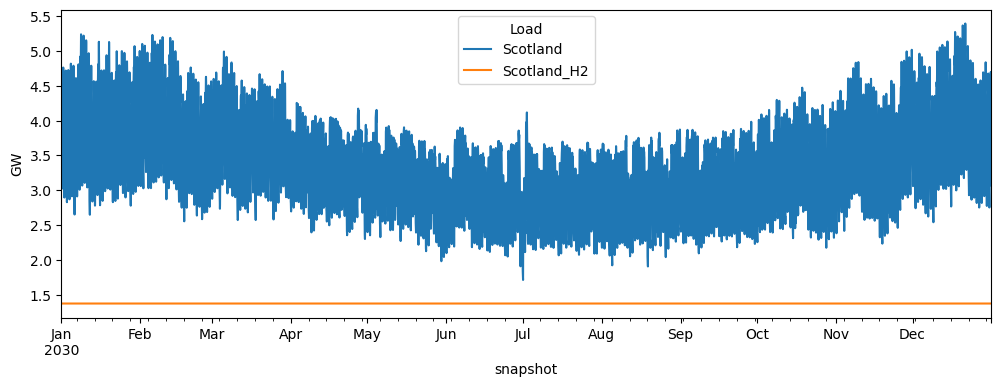

In [47]:
network.loads_t.p_set[['Scotland','Scotland_H2']].div(1e3).plot(figsize=(12,4), ylabel='GW')

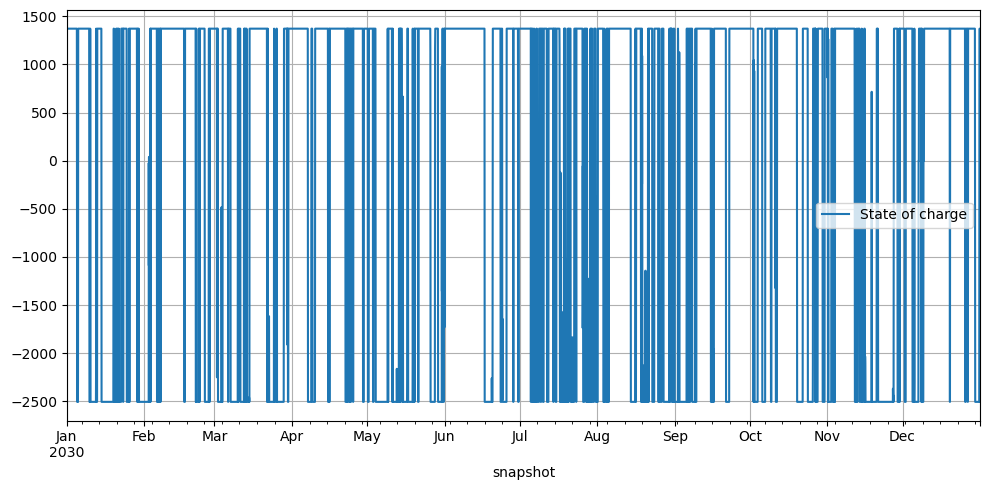

In [59]:
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {attr: network.stores_t[attr]["Scotland_H2_Storage"] for attr in ["p"]}
)
df.plot(grid=True, figsize=(10, 5))
plt.legend(labels=["State of charge"])
plt.tight_layout()


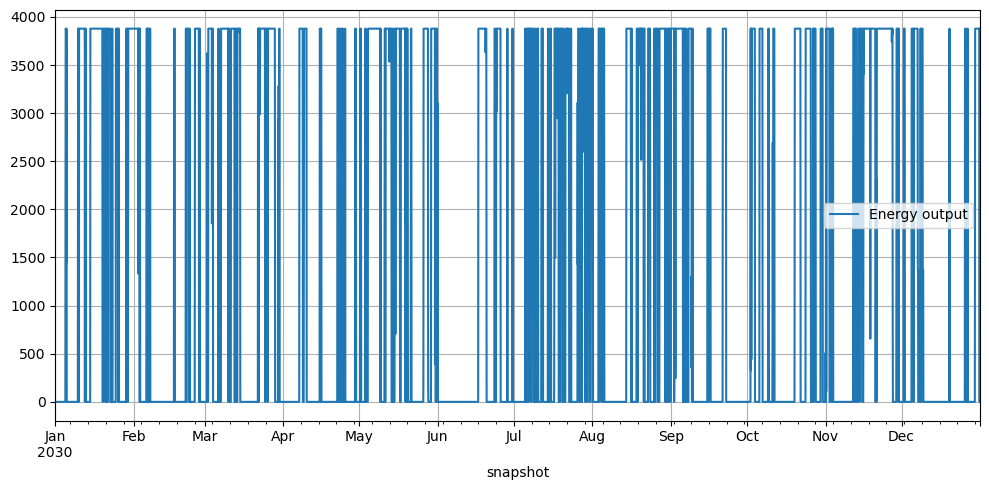

In [58]:
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {attr: network.links_t[attr]["Scotland_H2_Electrolysis"] for attr in ["p0"]}
)
df.plot(grid=True, figsize=(10, 5))
plt.legend(labels=["Energy output", "State of charge"])
plt.tight_layout()
